# 1. Imports

In [1]:
# Import practical libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Processing libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer


# Models libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
try:
    from xgboost import XGBClassifier
    xgb_available = True
except ImportError:
    xgb_available = False

# Evaluation libraries
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint, loguniform

# Intepretation
from sklearn.inspection import permutation_importance
import shap

# 2. Data Exploration

In [2]:
# Load data 
df = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_set = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

passenger_ids_test = test_set['PassengerId']

df.shape, test_set.shape, sample_submission.shape

((8693, 14), (4277, 13), (4277, 2))

In [3]:
sample_submission.sample(5)

,PassengerId,Transported
387,0812_01,False
2546,5577_01,False
3610,7874_02,False
1094,2324_01,False
3845,8408_02,False


In [4]:
# Initial data exploration
print("Dataset info:")
df.info()

print("\nDescriptive statistics:")
display(df.describe(include='all'))

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

Descriptive statistics:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [5]:
# Show % of missing values per feature
missing_percent = df.isnull().mean().sort_values(ascending=False) * 100
print("\nPercentage of missing values per column:")
print(missing_percent[missing_percent > 0])


Percentage of missing values per column:
CryoSleep       2.496261
ShoppingMall    2.392730
VIP             2.335212
HomePlanet      2.312205
Name            2.300702
Cabin           2.289198
VRDeck          2.162660
FoodCourt       2.105142
Spa             2.105142
Destination     2.093639
RoomService     2.082135
Age             2.059128
dtype: float64


In [6]:
# Remove fully duplicated rows if any
print(f"Removed {df.duplicated().sum()} duplicate rows")
df = df.drop_duplicates()

Removed 0 duplicate rows


# 3. EDA
Perform Exploratory Data Analysis


Target distribution:


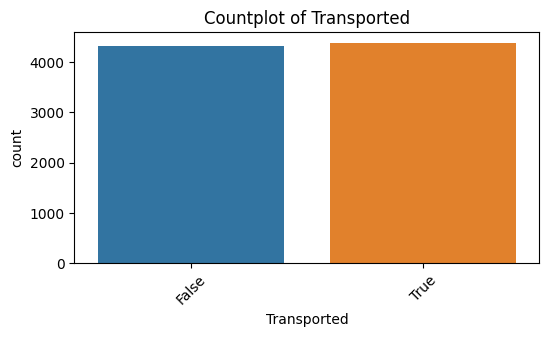

In [7]:
# Perform EDA:
col = 'Transported'
print("\nTarget distribution:")

plt.figure(figsize=(6, 3))
sns.countplot(data=df, x=col)
plt.title(f"Countplot of {col}")
plt.xticks(rotation=45)
plt.show()

### Observation: 
The target is Balanced - thus no balancing is neccesary

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


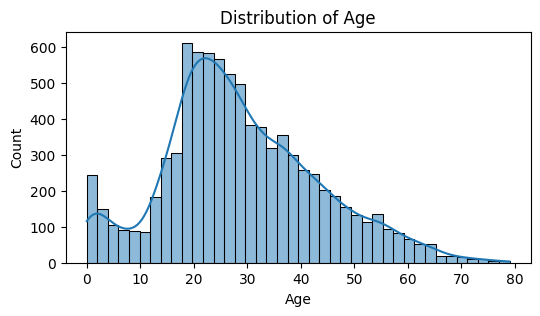

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


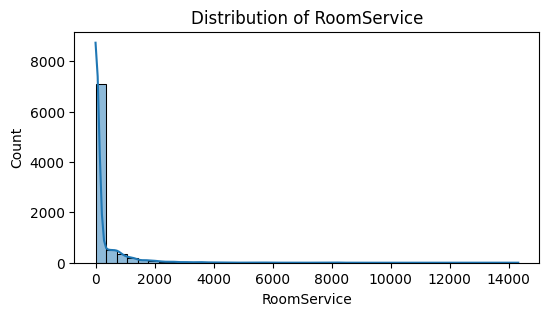

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


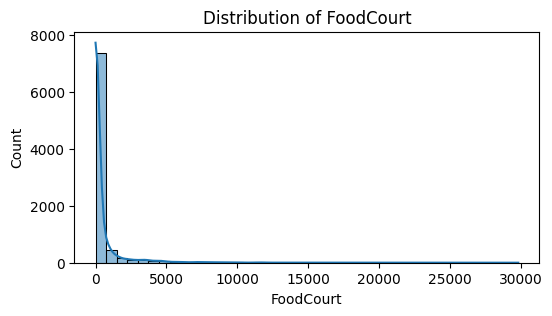

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


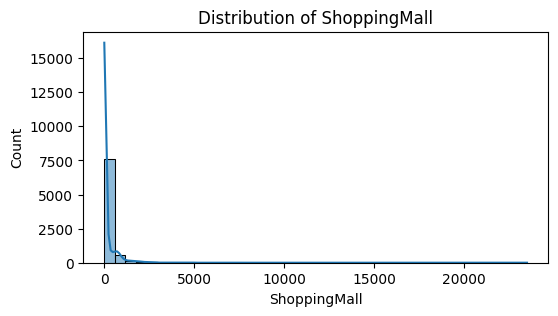

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


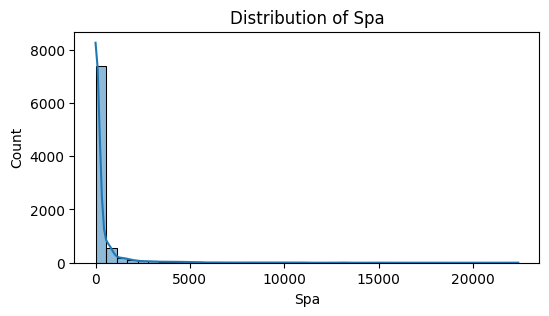

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


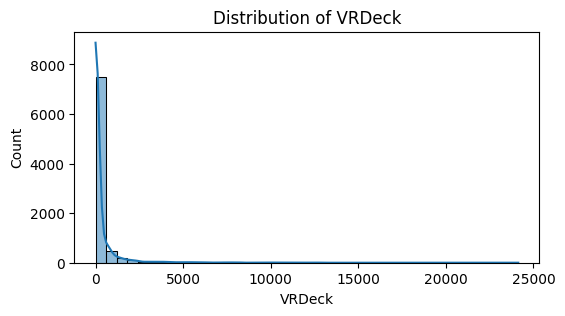

In [8]:
# Plot numerical feature distributions
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].dropna(), kde=True, bins=40)
    plt.title(f"Distribution of {col}")
    plt.show()

### Observation: 
Many of the numerical columns {"VRDeck", "Spa", "ShoppingMall", "FoodCourt", "RoomService"}, specificaly the expenses - seem to be right skewed
<br>
<br>
TODO: Possibly fix skewenes (perhaps by removing extreme values, from the higher Quartile)


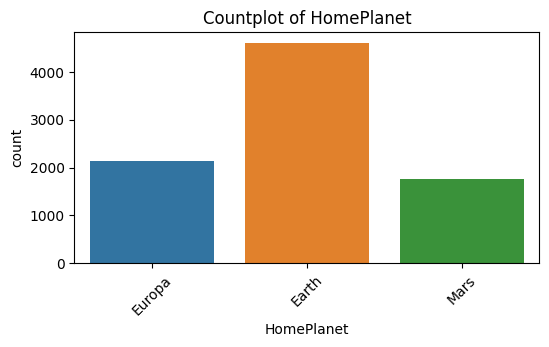

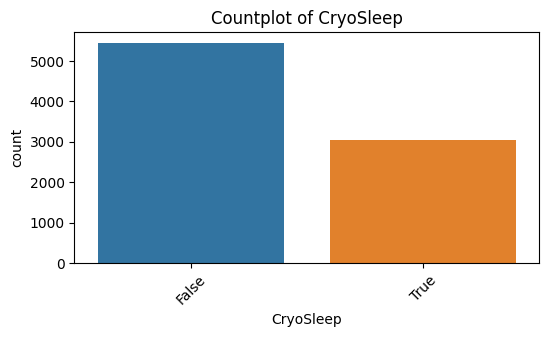

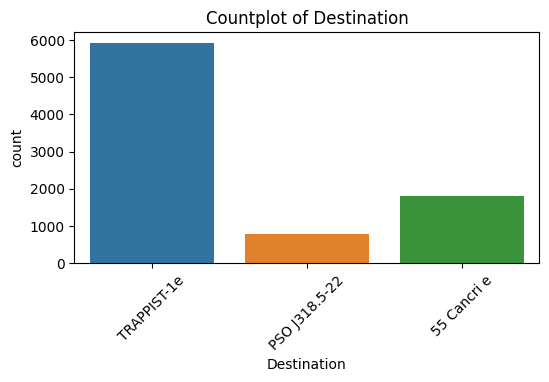

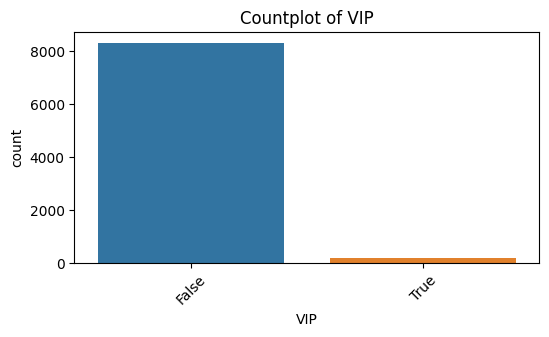

In [9]:
# Plot categorical feature counts
cat_cols = df.select_dtypes(include='object').columns.drop(['PassengerId', 'Name', 'Cabin'], errors='ignore')  # Remove "Cabin" because it will be converted afterwards to 3 different columns

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.xticks(rotation=45)
    plt.show()

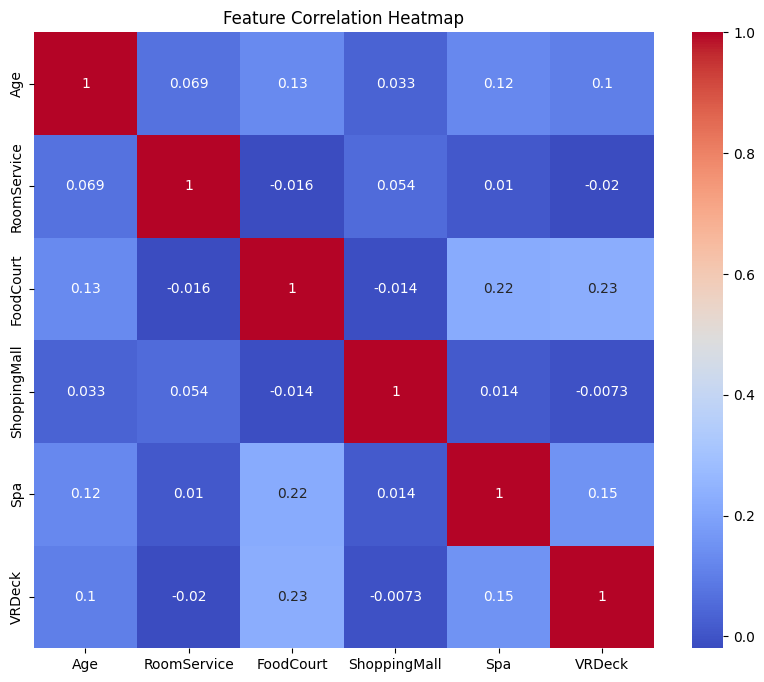

In [10]:
# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

### Observation:

Low correlations overall:<br>
Most features show weak correlations (~0), indicating low linear dependency between them.<br>
This suggests that the features capture different aspects of the data and are likely not redundant.<br>

Moderately correlated pairs:
* **_"FoodCourt"_** and **_"VRDeck"_**: 0.23
* **_"FoodCourt"_** and **_"Spa"_**: 0.22
* **_"Spa"_** and **_"VRDeck"_**: 0.15
Interpretation: These suggest that people who spent money in one amenity are slightly more likely to have spent in others.
<br><br>
Age correlations:
* **_"Age"_** shows weak positive correlations with all features, highest with **_"FoodCourt"_** (0.13), **_"Spa"_** (0.12) and **_"VRDeck"_** (0.1).
Interpretation: Older passengers may spend slightly more, but the actual effect is minimal.

# 4. Feature Engineering 

In [11]:
# Drop 'Name' column (irelevant for training)
# split 'Cabin' - split to 'Room number', 'Deck' and 'Side' 
# Create 'TotalSpent' - a Combination of the person's expenses on the spaceship
def feature_engineering(df):
    df.drop(columns=['Name'], inplace=True, errors='ignore')
    df[['Deck', 'RoomNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df.drop(columns='Cabin', inplace=True)
    df['RoomNum'] = pd.to_numeric(df['RoomNum'], errors='coerce')
    df['TotalSpent'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
    # 4. Binarise high spenders
    df["VIP_or_HighSpend"] = (df["VIP"] == True) | (df["TotalSpent"] > df["TotalSpent"].median())    
    # 5. Because the expenses are very skewed, we'll add a binary > 0 column for each of them, so that the relevant models will just take care of the spending
    for col in ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck", "TotalSpent"]:
        df[col + "_log"]  = np.log1p(df[col])        # compressed value
        df[col + "_flag"] = (df[col] > 0).astype(int)  # 0/1 spender
    
    return df

df = feature_engineering(df)
test_set = feature_engineering(test_set)

df.shape, test_set.shape

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/p

((8693, 29), (4277, 28))

In [12]:
# Describe the new variables:
df[["Deck", "Side", "RoomNum", "VIP_or_HighSpend","TotalSpent"]].describe(include="all")

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Deck,Side,RoomNum,VIP_or_HighSpend,TotalSpent
count,8494,8494,8494.000000,8693,8693.000000
unique,8,2,NaN,2,NaN
top,F,S,NaN,True,NaN
freq,2794,4288,NaN,4375,NaN
mean,NaN,NaN,600.367671,NaN,1440.866329
std,NaN,NaN,511.867226,NaN,2803.045694
min,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,NaN,167.250000,NaN,0.000000
50%,NaN,NaN,427.000000,NaN,716.000000
75%,NaN,NaN,999.000000,NaN,1441.000000


# 5. EDA - Continue

Perform EDA on the new features, and the relationship of the new features with the existing features

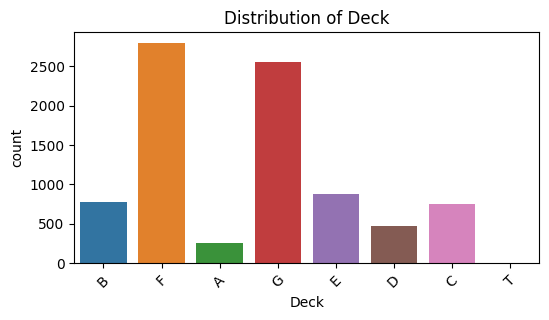

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


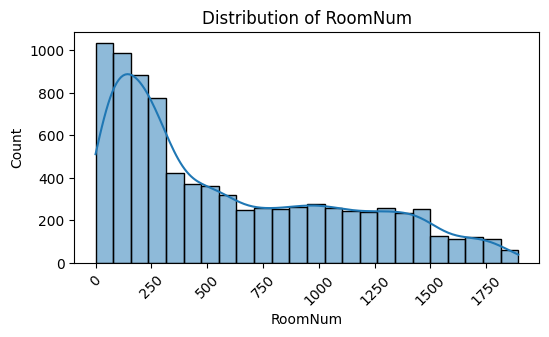

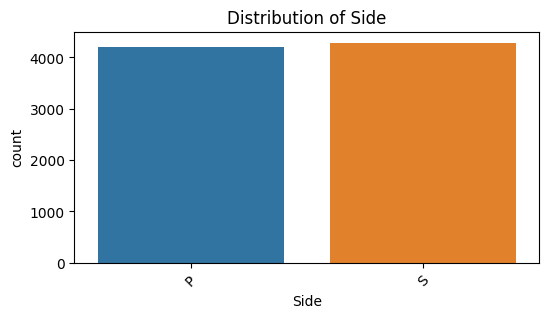

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


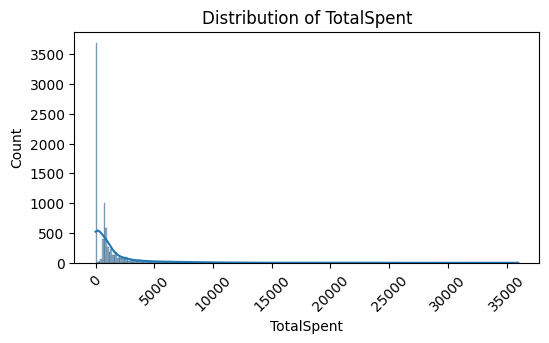

In [13]:
new_features = ['Deck', 'RoomNum', 'Side', 'TotalSpent']

for col in new_features:
    plt.figure(figsize=(6, 3))
    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col)
    else:
        sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

### Observation:

#### _"Deck"_:**
*  Dichotomic populated areas between the low and high (mostly populated in E, F, G, and medium to low populated in A-D), Might be predictive socioeconomic status
*  TODO: Take into consideration add a binary feature of socioeconomic status based on this column

#### _"RoomNum"_:
* Right Skewed. Could reflect cabin location or also class.
* TODO: A normalization/binning might be benificial

#### _"Side"_:
* Balanced.
* Might be a relevant predictor of survival

#### _"TotalSpent"_:
* Highly Right skewed, with extreme common value.
* Most passengers spent very little, but a few spent large amounts (potentially VIPs).
* Consider log scaling to deal with the bias

# 6. Data Preparation for Modeling

In [1]:
# Prepare features and target for modeling
y = df['Transported']
X = df.drop(columns=['Transported', 'PassengerId'])

NameError: name 'df' is not defined

In [15]:
# Identify column types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

print(f"Numerical Features are: \n{num_cols}")
print("\n\n")
print(f"Categorical Features are: \n{cat_cols}")

Numerical Features are: 
['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomNum', 'TotalSpent', 'RoomService_log', 'RoomService_flag', 'FoodCourt_log', 'FoodCourt_flag', 'ShoppingMall_log', 'ShoppingMall_flag', 'Spa_log', 'Spa_flag', 'VRDeck_log', 'VRDeck_flag', 'TotalSpent_log', 'TotalSpent_flag']



Categorical Features are: 
['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']


In [16]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6954, 27), (1739, 27), (6954,), (1739,))

## 7. Define Pipeline

In [17]:
# Define preprocessing pipelines

# --- two numeric pipes: scaled vs. raw ---
num_scaled = Pipeline([
    ("impute", KNNImputer(n_neighbors=5, weights="uniform")),  # Fill Nans using KNNImpouter
    ("scale" , StandardScaler())                               # Scale after imputing
])

num_raw = Pipeline([
    ("impute", KNNImputer(n_neighbors=5, weights="uniform"))   # Fill Nans using KNNImputer. No scaling is required for tree based models
])

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),       # Fill Nans using the simple imputer
    ("ohe"   , OneHotEncoder(handle_unknown="ignore"))         # Scale after imputing
])

preproc_scaled   = ColumnTransformer([("num", num_scaled,   num_cols),
                                      ("cat", cat_pipe,    cat_cols)])

preproc_unscaled = ColumnTransformer([("num", num_raw,     num_cols),
                                      ("cat", cat_pipe,    cat_cols)])


# 8. Define Models and Hyperparameter Grids

In [18]:
# 10. Define models and hyperparameter grids
models = {
    # Scale-sensitive algorithms (need preproc_scaled)
    "logreg": dict(
        pipe   = Pipeline([
            ("prep", preproc_scaled),
            ("clf" , LogisticRegression(max_iter=2000, random_state=42))
        ]),
        params = {"clf__C": loguniform(1e-3, 1e3)}
    ),

    "svc": dict(
        pipe   = Pipeline([
            ("prep", preproc_scaled),
            ("clf" , SVC(random_state=42))
        ]),
        params = {
            "clf__C": loguniform(1e-2, 1e2),
            "clf__kernel": ["linear", "rbf"],
            "clf__gamma" : ["scale", "auto"]
        }
    ),

    "knn": dict(
        pipe   = Pipeline([
            ("prep", preproc_scaled),
            ("clf" , KNeighborsClassifier())
        ]),
        params = {
            "clf__n_neighbors": randint(3, 15),
            "clf__weights"    : ["uniform", "distance"]
        }
    ),

    # Scale-invariant tree / boosting models (preproc_unscaled)
    "rf": dict(
        pipe   = Pipeline([
            ("prep", preproc_unscaled),
            ("clf" , RandomForestClassifier(random_state=42))
        ]),
        params = {
            "clf__n_estimators"     : randint(300, 900),
            "clf__max_depth"        : [None, 8, 16, 24],
            "clf__min_samples_split": randint(2, 10)
        }
    ),

    "gb": dict(
        pipe   = Pipeline([
            ("prep", preproc_unscaled),
            ("clf" , GradientBoostingClassifier(random_state=42))
        ]),
        params = {
            "clf__n_estimators" : randint(200, 800),
            "clf__learning_rate": loguniform(1e-3, 1e-1),
            "clf__max_depth"    : [2, 3, 4, 5]
        }
    ),

    "hgb": dict(
        pipe   = Pipeline([
            ("prep", preproc_unscaled),
            ("clf" , HistGradientBoostingClassifier(random_state=42))
        ]),
        params = {
            "clf__learning_rate"   : loguniform(1e-3, 1e-1),
            "clf__max_depth"       : [None, 3, 5, 7],
            "clf__l2_regularization": loguniform(1e-3, 1)
        }
    )
} 


# 9. Fit Models
Over the training set, and perform first evalueation using cross validation 

In [19]:
# Fit the model on the training set using cross validation.
# N_FOLDS = 10   # 5
N_FOLDS = 5   # 5
cv_inner   = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
best_score = 0
best_name  = None
best_est   = None
# N_RAND_COMBOS = 40 # 3  
N_RAND_COMBOS = 3  

for name, cfg in models.items():
    print(f"\n{name}")
    rs = RandomizedSearchCV(estimator=cfg["pipe"],
                            param_distributions=cfg["params"],
                            n_iter=N_RAND_COMBOS,
                            cv=cv_inner,
                            scoring="accuracy",
                            n_jobs=-1,
                            random_state=42,
                            verbose=0)
    rs.fit(X_train, y_train)
    print(f"    best CV accuracy = {rs.best_score_:.4f}")
    if rs.best_score_ > best_score:
        best_score, best_name, best_est = rs.best_score_, name, rs.best_estimator_



logreg
    best CV accuracy = 0.7934

svc
    best CV accuracy = 0.7919

knn
    best CV accuracy = 0.7883

rf
    best CV accuracy = 0.7982

gb
    best CV accuracy = 0.7885

hgb
    best CV accuracy = 0.8051


# 12. Models Evaluation
Assess model performance on the validation set to guide model selection and tuning before proceeding to final evaluation on the test set.

Evaluation over the validation set:
Validation accuracy = 0.8160

              precision    recall  f1-score   support

       False      0.823     0.802     0.812       863
        True      0.810     0.830     0.820       876

    accuracy                          0.816      1739
   macro avg      0.816     0.816     0.816      1739
weighted avg      0.816     0.816     0.816      1739



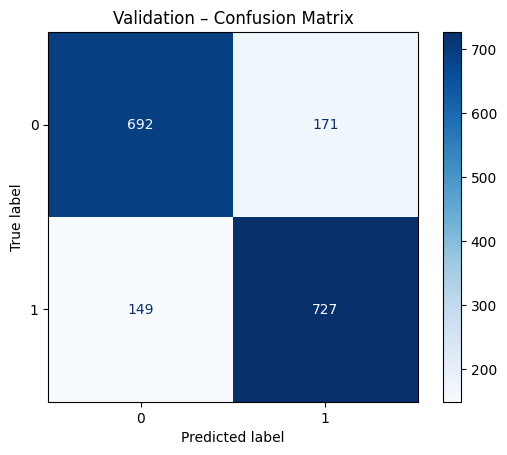

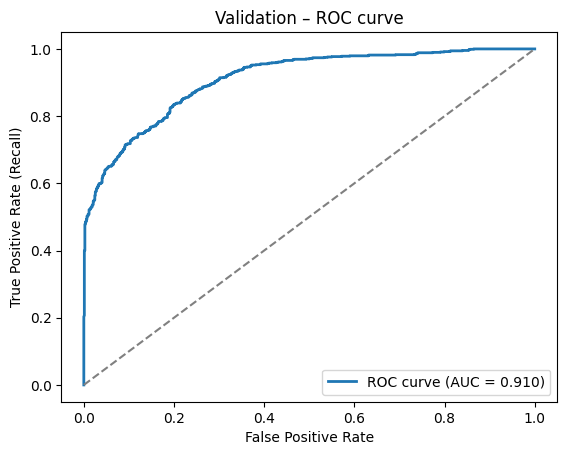

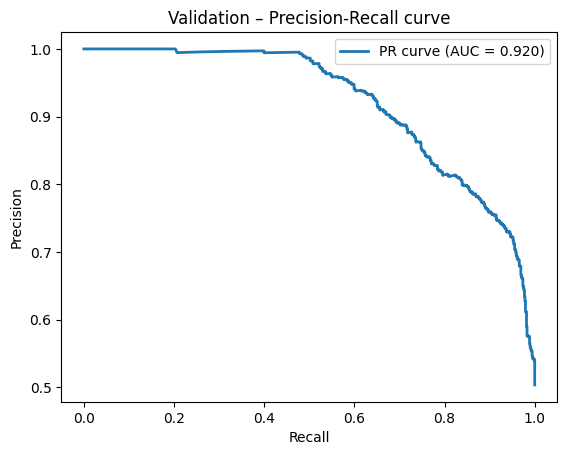

In [22]:
# Assess model performance on the validation set

def evaluate_model(model, X_val, y_val, title="Validation"):
    # probability scores
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:, 1]
    else:                      # e.g. SVC(probability=False)
        y_scores = model.decision_function(X_val)

    y_pred = model.predict(X_val)

    # basic report & confusion matrix
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation accuracy = {acc:.4f}\n")
    
    print(classification_report(y_val, y_pred, digits=3))
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"{title} – Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = roc_auc_score(y_val, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"{title} – ROC curve")
    plt.legend()
    plt.show()

    # Precision–Recall curve
    prec, rec, _ = precision_recall_curve(y_val, y_scores)
    pr_auc = average_precision_score(y_val, y_scores)

    plt.figure()
    plt.plot(rec, prec, lw=2, label=f"PR curve (AUC = {pr_auc:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} – Precision-Recall curve")
    plt.legend()
    plt.show()

    return acc

# call it after selecting best_est
print("Evaluation over the validation set:")

val_accuracy_score = evaluate_model(best_est, X_val, y_val)


## Observations:

### Accuracy Score:
* The model is balanced: it does not systematically prefer one class over the other.
* Both classes are predicted with similar quality.


### Confusion Matrix:
* Errors are similar in both directions (171 vs. 149), indicating no major bias towards predicting “True” or “False”.
* The majority of predictions are correct.

### ROC Curve:
* The model is excellent at distinguishing between the two classes (well above the random 0.5 score).
* The model can effectively separate transported from not transported passengers over various thresholds.

### Precision-Recall Curve:
* High average precision across all recall levels (model maintains good precision even as recall increases).
* The model’s predictions for the “True” class (Transported) are robust and reliable.


# 13. Model Interpretibility

Analyze the model's predictions to understand which features influence the output, and extract actionable insights.

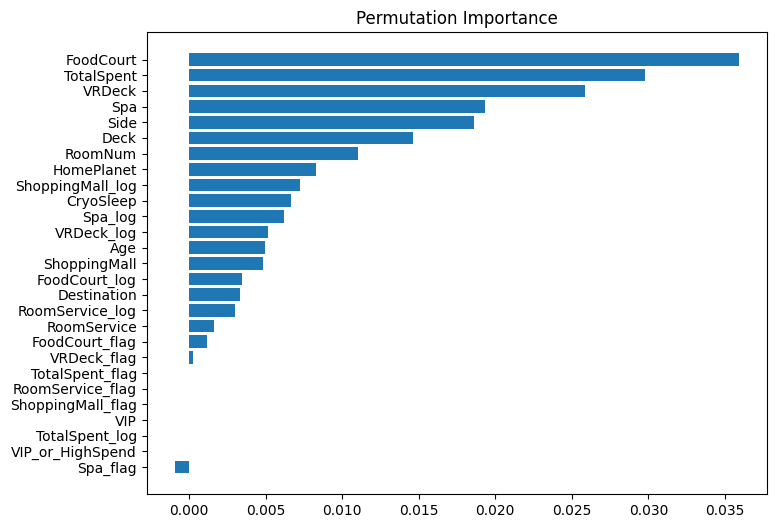

In [29]:
perm = permutation_importance(best_est, X_val, y_val, n_repeats=5, random_state=42)
sorted_idx = perm.importances_mean.argsort()

plt.figure(figsize=(8, 6))
plt.barh(X_val.columns[sorted_idx], perm.importances_mean[sorted_idx])
plt.title("Permutation Importance")
plt.show()

## Observation:

The permutation importance plot reveals that features related to passenger spending, especially FoodCourt, TotalSpent, and VRDeck, are the most predictive for whether a passenger was transported. <br>
Whereas features like age, and expension logs had medium affect on the prediction <br>
And the addition flag features had little to zero impact.<br>

## Model Improvement Ideas:

Feature Engineering:<br>
Consider further engineering for the high effect features: e.g. combining spending features — perhaps ratios (e.g., FoodCourt/TotalSpent), clusters of spending behavior, or interaction terms.

Feature Selection: <br>
Removing the low-importance flags for a cleaner and slightly faster model (a marginal effect on performance).

Investigate Relationships: <br>
Since spending dominates, further check for possible data leakage might be required (are these features in any way derived from the target?)

Medium-effect - Feature Enhancement: <br>
Check to see if I can boost the predictive power of the medium effect features (demographic/categorical features - HomePlanet, CryoSleep, etc.) via better preprocessing or combining them.

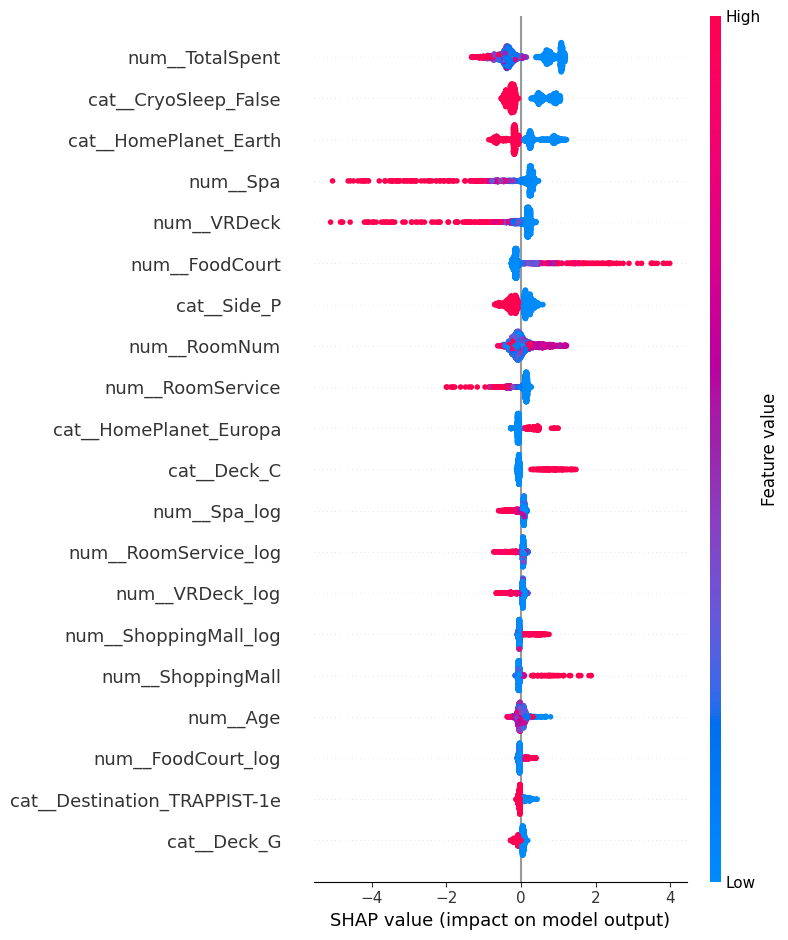

In [25]:
# Direction interpretibiility using SHAP

# Step 1: Get transformed validation data and final classifier
X_val_trans = best_est.named_steps['prep'].transform(X_val)
clf = best_est.named_steps['clf']

# Step 2: Try to get feature names from the preprocessor
try:
    feature_names = best_est.named_steps['prep'].get_feature_names_out()
except AttributeError:
    feature_names = None

# Step 3: SHAP interpretation
explainer = shap.Explainer(clf, X_val_trans)
shap_values = explainer(X_val_trans, check_additivity=False)

# Step 4: Plot
shap.summary_plot(shap_values, X_val_trans, feature_names=feature_names if feature_names is not None else None)

## Observations:

Based on the SHAP interpretation:<br>
_"num__TotalSpent"_ is the most impactful feature in the model.
<br><br>
Other highly important features include {_"cat__CryoSleep_False"_, _"cat__HomePlanet_Earth"_, _"num__Spa"_, _"num__VRDeck"_, _"num__FoodCourt"_, _"num__Age"_, _"cat__Side_P"_, _"num__RoomService"_, _"cat__Destination_TRAPPIST-1e"_}



In [44]:
# Check for the correlation between the "TotalSpent" and the features combining it, to check if one or more should be removed in case of high correlation

component_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
correlations = {}

for col in component_cols:
    corr = X_val['TotalSpent'].corr(X_val[col])
    correlations[col] = corr

# Print results
for col, corr in correlations.items():
    print(f"TotalSpent & {col}: {corr:.3f}")


TotalSpent & RoomService: 0.199
TotalSpent & FoodCourt: 0.754
TotalSpent & ShoppingMall: 0.270
TotalSpent & Spa: 0.579
TotalSpent & VRDeck: 0.634


In [58]:
# Transform validation data and ensure feature names are present
X_val_trans = best_est.named_steps['prep'].transform(X_val)
feature_names = best_est.named_steps['prep'].get_feature_names_out()
X_val_trans_df = pd.DataFrame(X_val_trans, columns=feature_names)

# Get the classifier
clf = best_est.named_steps['clf']

# Calculate SHAP values using the DataFrame
explainer = shap.Explainer(clf, X_val_trans_df)
shap_values = explainer(X_val_trans_df, check_additivity=False)

# Predict labels
y_pred = best_est.predict(X_val)

# Find indices for false positives and true negatives
false_positives = np.where((y_pred == 1) & (y_val.values == 0))[0]
false_negatives  = np.where((y_pred == 0) & (y_val.values == 1))[0]

num_plots = 5
rng = np.random.default_rng(seed=42)  # or use np.random.seed for legacy
fp_sample = rng.choice(false_positives, size=min(num_plots, len(false_positives)), replace=False)
fn_sample = rng.choice(false_negatives, size=min(num_plots, len(false_negatives)), replace=False)


False Positive at index 1250: predicted=1, true=0
Raw model output (f(x)): 0.317 | Probability: 0.579


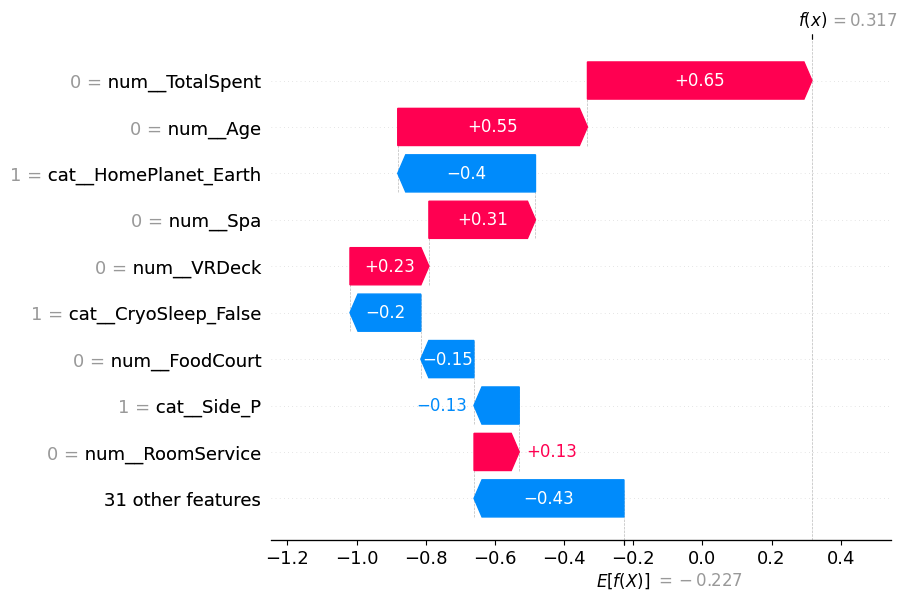


False Positive at index 657: predicted=1, true=0
Raw model output (f(x)): 0.139 | Probability: 0.535


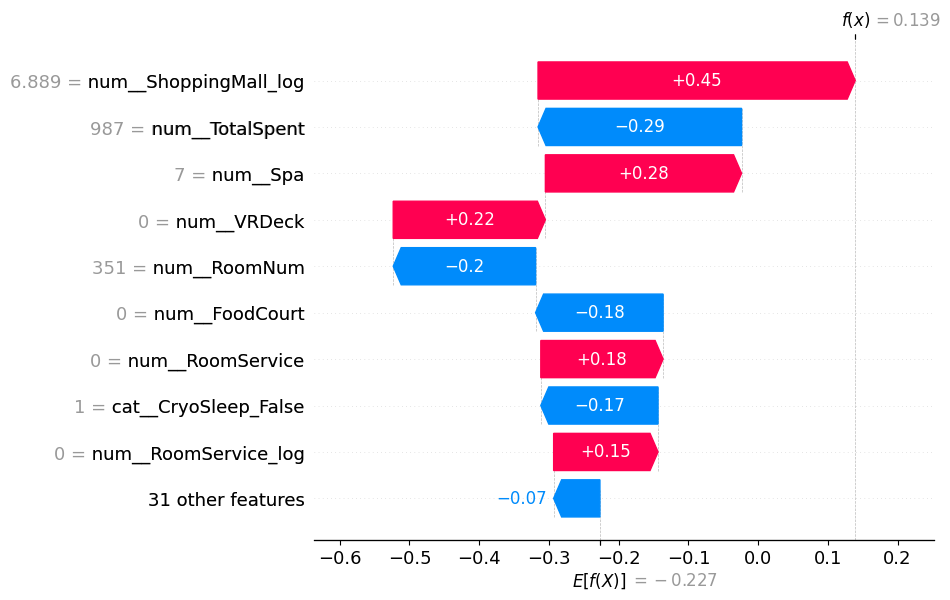


False Positive at index 1034: predicted=1, true=0
Raw model output (f(x)): 0.198 | Probability: 0.549


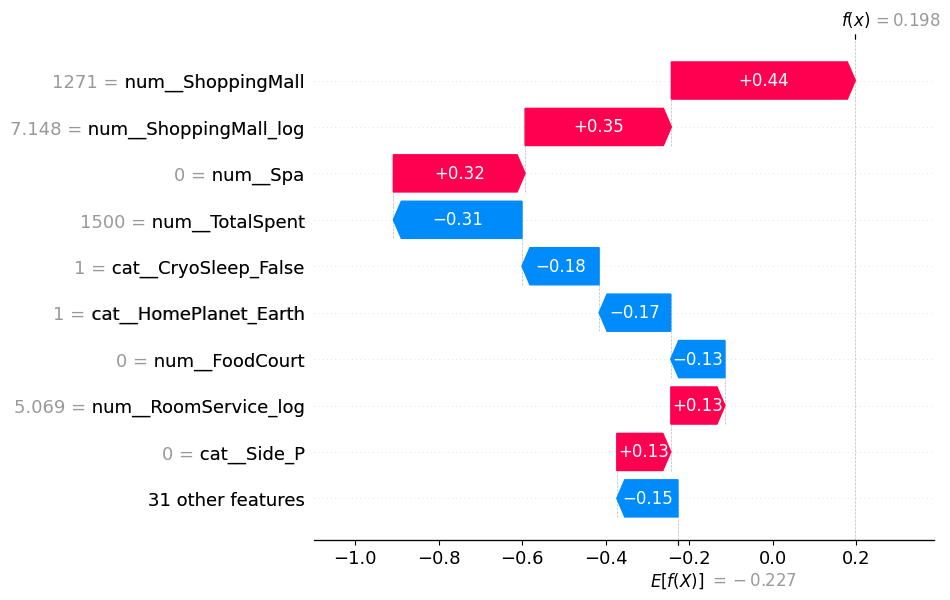


False Positive at index 122: predicted=1, true=0
Raw model output (f(x)): 0.740 | Probability: 0.677


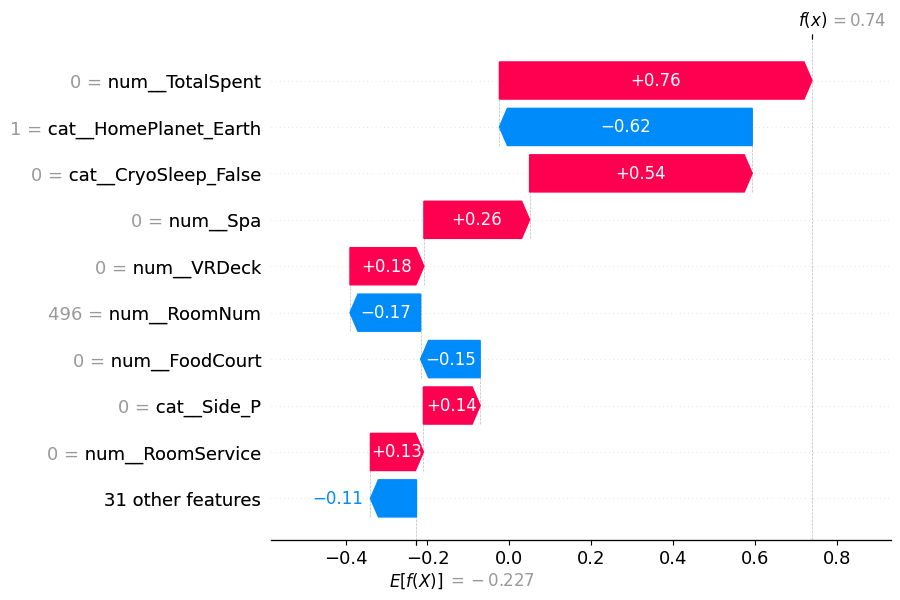


False Positive at index 1727: predicted=1, true=0
Raw model output (f(x)): 0.603 | Probability: 0.646


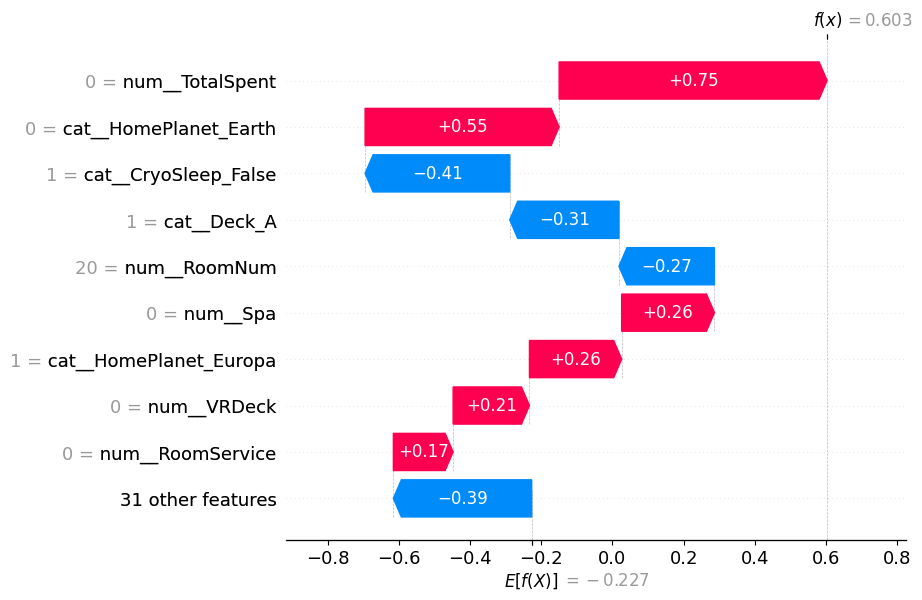

In [63]:
# Plot several False Positive Examples
# Plot SHAP waterfall with feature names
for idx in fp_sample:
    fx = shap_values[idx].values.sum() + shap_values.base_values[idx]
    prob = 1 / (1 + np.exp(-fx))
    print(f"\nFalse Positive at index {idx}: predicted=1, true=0")
    print(f"Raw model output (f(x)): {fx:.3f} | Probability: {prob:.3f}")
    shap.plots.waterfall(shap_values[idx])


False Negative at index 1660: predicted=0, true=1
Raw model output (f(x)): -0.781 | Probability: 0.314


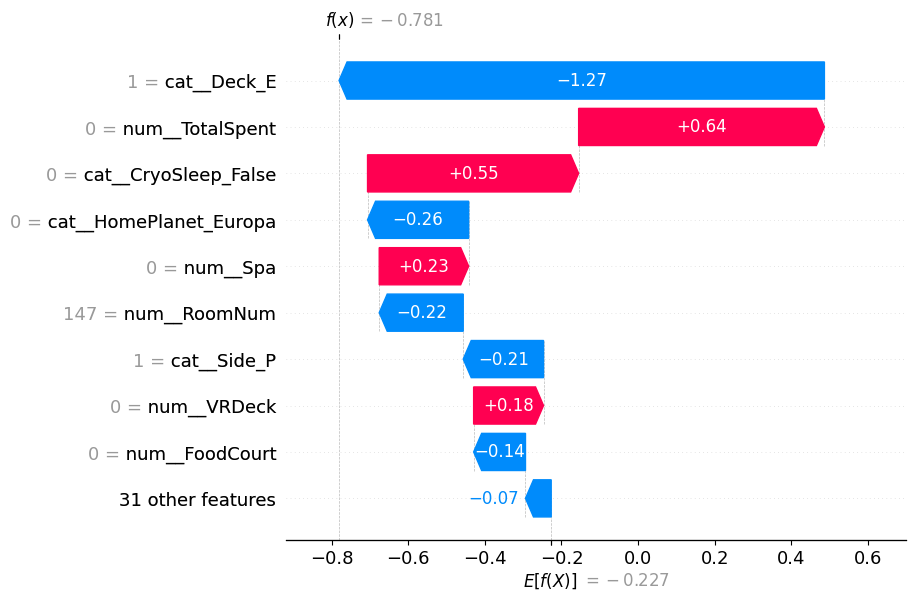


False Negative at index 187: predicted=0, true=1
Raw model output (f(x)): -0.036 | Probability: 0.491


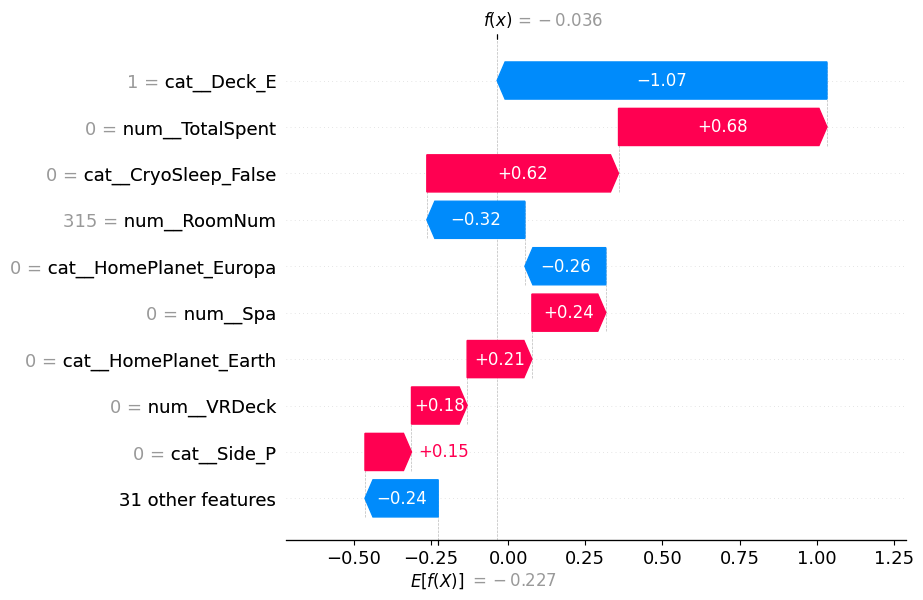


False Negative at index 822: predicted=0, true=1
Raw model output (f(x)): -2.209 | Probability: 0.099


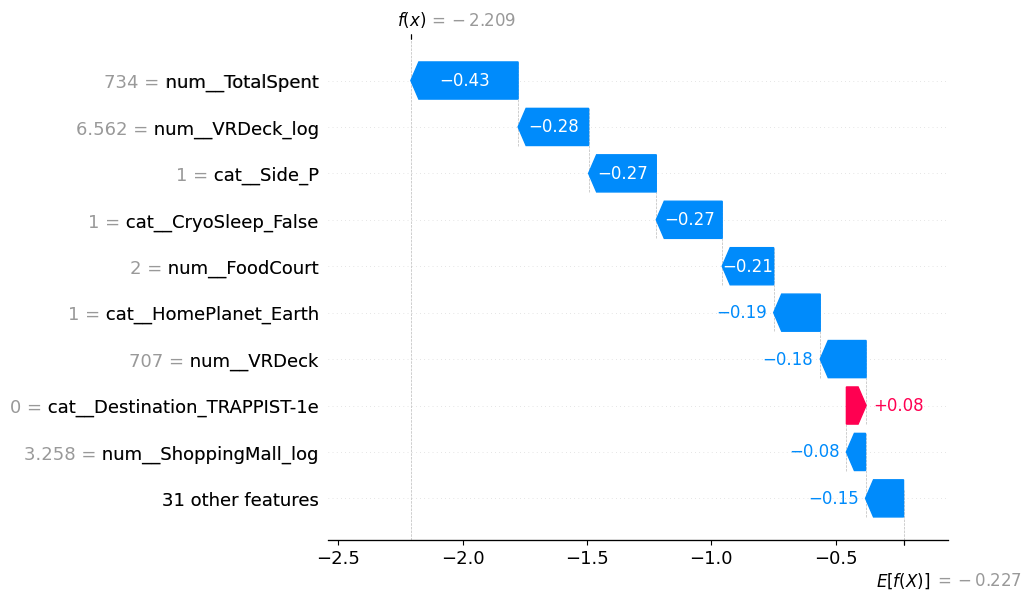


False Negative at index 1259: predicted=0, true=1
Raw model output (f(x)): -1.280 | Probability: 0.218


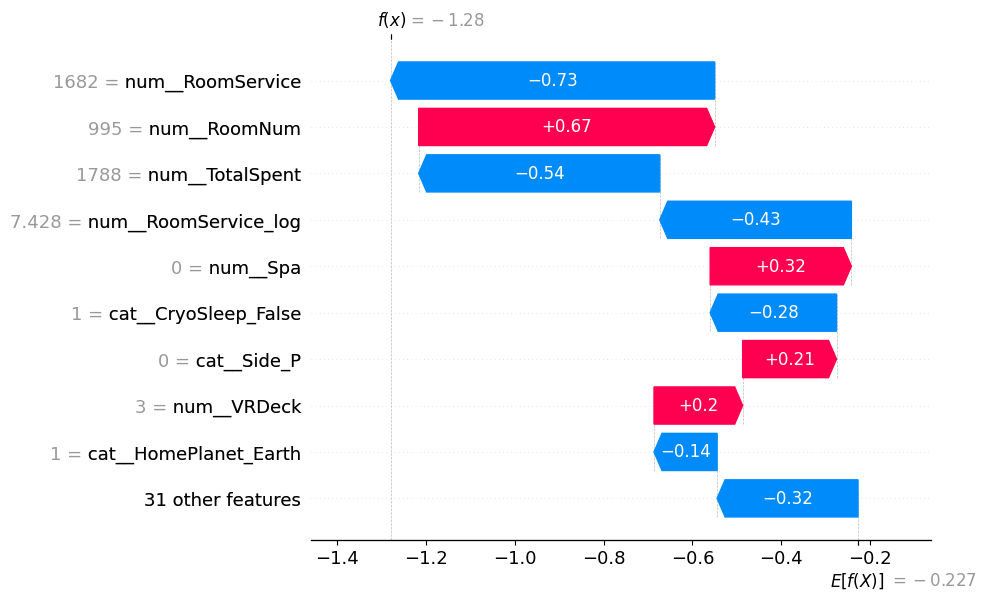


False Negative at index 1178: predicted=0, true=1
Raw model output (f(x)): -0.103 | Probability: 0.474


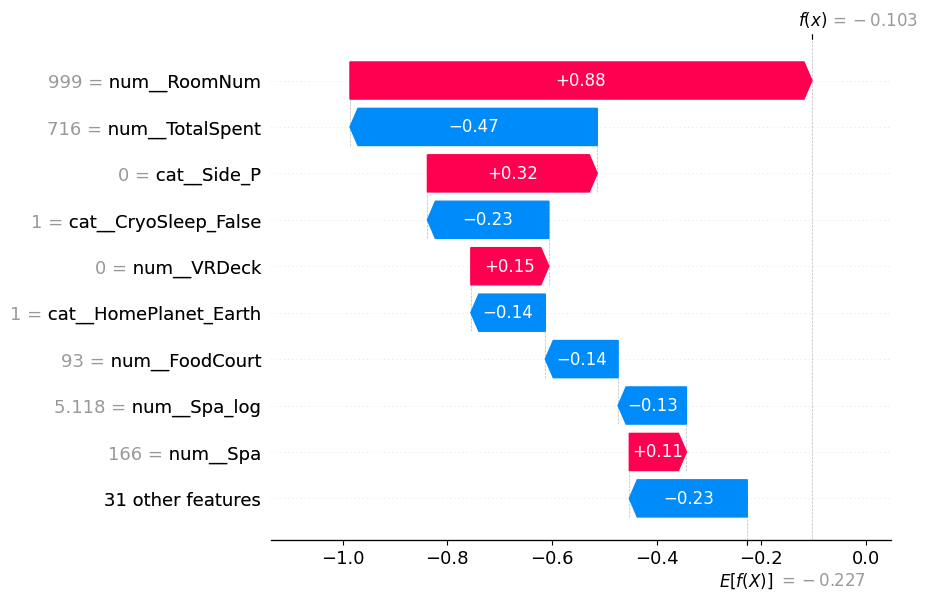

In [64]:
# Plot several False Negative Examples
for idx in fn_sample:
    fx = shap_values[idx].values.sum() + shap_values.base_values[idx]
    prob = 1 / (1 + np.exp(-fx))
    print(f"\nFalse Negative at index {idx}: predicted=0, true=1")
    print(f"Raw model output (f(x)): {fx:.3f} | Probability: {prob:.3f}")
    shap.plots.waterfall(shap_values[idx])

TODO: Add observations about the one sample examples 
If I see any pattern, any features that plays a pivotal / strong role, anything with the scores (if they are boarderlined and not extremely weird, or perhaps how many are boarderlined and how many are extreme) 

TODO: Possibly add a couple of False-positives and a couple of True-negative to try and see for a pattern (direction specific pattern, or a general pattern)

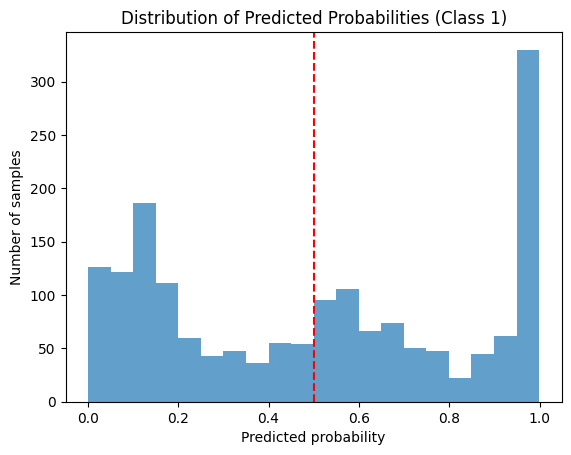

In [65]:
# Histogram of predicted probabilities (to check for sureness in the prediction)

probs = best_est.predict_proba(X_val)[:, 1]  # Prob of class 1

plt.hist(probs, bins=20, alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--')
plt.title("Distribution of Predicted Probabilities (Class 1)")
plt.xlabel("Predicted probability")
plt.ylabel("Number of samples")
plt.show()

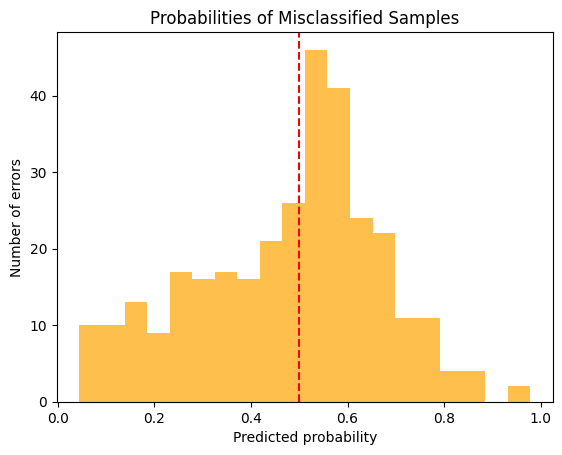

In [66]:
# Plot of the errors to check and see if the model is very sure and thus shows an extreme error in understanding of a feature for example, or it just needs a bit more tune
is_error = (y_pred != y_val.values)
plt.hist(probs[is_error], bins=20, color='orange', alpha=0.7)
plt.axvline(0.5, color='red', linestyle='--')
plt.title("Probabilities of Misclassified Samples")
plt.xlabel("Predicted probability")
plt.ylabel("Number of errors")
plt.show()

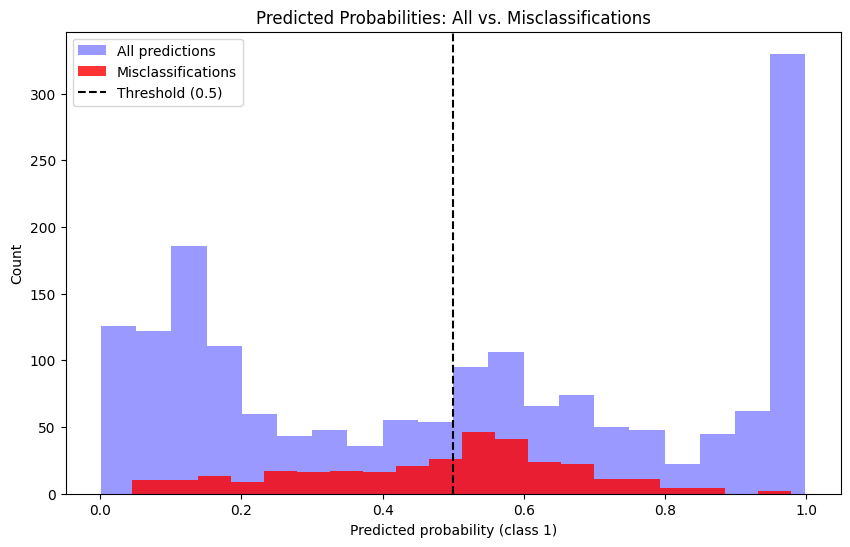

In [67]:
# Get predicted probabilities for class 1
probs = best_est.predict_proba(X_val)[:, 1]
# Identify misclassified samples
is_error = (y_pred != y_val.values)

plt.figure(figsize=(10,6))
# Plot all predictions
plt.hist(probs, bins=20, alpha=0.4, label="All predictions", color='blue')
# Overlay misclassified samples
plt.hist(probs[is_error], bins=20, alpha=0.8, label="Misclassifications", color='red')

plt.axvline(0.5, color='black', linestyle='--', label='Threshold (0.5)')
plt.xlabel("Predicted probability (class 1)")
plt.ylabel("Count")
plt.title("Predicted Probabilities: All vs. Misclassifications")
plt.legend()
plt.show()

TODO: After understanding and finishing the interpretation (SHAP and observations extraction from it), try to improve the dataset (feature engineering etc... as found in the observation after the permutation), followed by retraining the models and evaluate of-course

# 14. Retrain
Retrain over the entire df (the train & validation sets) to get the most reliable score and potentialy increase performence on the test set

In [ ]:
# Finally - Retrain on full train & valistaion sets and create submission
best_est.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# 15. Predict & Save
Predict the scores over the test set, and save the results over the submission file template to a .csv

In [ ]:
test_preds = best_est.predict(test_set)

In [ ]:
submission = pd.DataFrame({
    "PassengerId": passenger_ids_test,
    "Transported": test_preds
})

submission

In [ ]:
val_tag  = f"{val_accuracy_score:.4f}".replace(".", "")      # e.g. 0.8231 → "08231"
output_file_name = f"{best_name}_{val_tag}.csv"
submission.to_csv(output_file_name, index=False)
print(f"submission.csv written to {output_file_name}")

<br>
TODO: Edit documentation - <br>
1. Add sub-sections <br>
2. possibly toggle sections for more comfortable view<br>
